# Demo:  PCA Eigen-Faces

In this demo, we will illustrate how to compute the PCA for a simple data set and use it as a visualization tool, and how to use PCA coefficients for classification (face recognition) using SVM classifier.

## Loading the data

We begin by loading the standard packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

We will demonstrate PCA on a face dataset taken from news articles about 10 years ago.  The full data set has thousands of faces, but we will use a small subset here.  Since this data set is widely-used, it is installed as part of the `sklearn`  

We first download the data.  This is large and can take several minutes.

In [2]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Once the data is loaded, we can get see the dimensions

In [3]:
# Get images
n_samples, h, w = lfw_people.images.shape
npix = h*w

# Data in 2D form
X = lfw_people.data
n_features = X.shape[1]

# Labels of images 
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Image size     = {0:d} x {1:d} = {2:d} pixels".format(h,w,npix))
print("Number faces   = {0:d}".format(n_samples))
print("Number classes = {0:d}".format(n_classes))


Image size     = 50 x 37 = 1850 pixels
Number faces   = 1288
Number classes = 7


## Plotting the Faces

We will plot a few faces to look at the dataset.

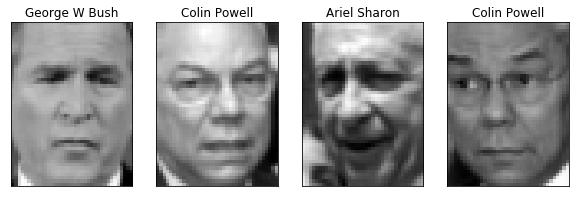

In [4]:
def plt_face(x):
    h = 50
    w = 37
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    
I = np.random.permutation(n_samples)
plt.figure(figsize=(10,20))
nplt = 4;
for i in range(nplt):    
    ind = I[i]
    plt.subplot(1,nplt,i+1)
    plt_face(X[ind])
    plt.title(target_names[y[ind]])

## Compute the PCA

First, we subtract the mean from the data set.

In [5]:
npix = h*w
Xmean = np.mean(X,0)
Xs = X - Xmean[None,:]

Then, we compute an SVD.  Note that in python the SVD returns `V` not `V.T`.  Also, you should include the `full_matrices` option to get the *economy* SVD

In [6]:
U,S,V = np.linalg.svd(Xs, full_matrices=False)

We can plot the proportion of variance as a function of the number of PCs

Text(0,0.5,'PoV')

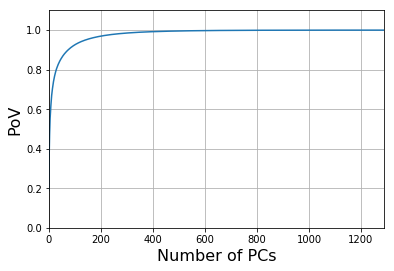

In [7]:
lam = S**2
PoV = np.cumsum(lam)/np.sum(lam)

plt.plot(PoV)
plt.grid()
plt.axis([1,n_samples,0, 1.1])
plt.xlabel('Number of PCs', fontsize=16)
plt.ylabel('PoV', fontsize=16)

We can reconstruct the faces using only first few PCs

In [8]:
nsvd = 20
Xhat = (U[:,:nsvd]*S[None,:nsvd]).dot(V[:nsvd,:])
Xhat = Xhat + Xmean[None,:]

In [9]:
Xhat.shape
#show_face(Xhat[i,:], target_names[y[i]])

(1288, 1850)

In [10]:
# Note that instead of using linalg.svd, one can also use PCA method in sklearn

from sklearn.decomposition import PCA
pca = PCA(n_components=nsvd, svd_solver='randomized',
          whiten=True).fit(Xs)
eigenfaces = pca.components_
X_pca_coefficients = pca.transform(Xs)

## Now we plot the reconstructed images from increasing number of PCs

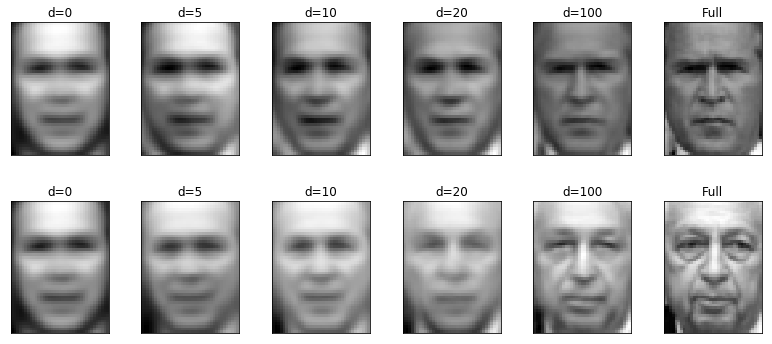

In [11]:
nplt = 2               # number of faces to plot
ds = [0,5,10,20,100]   # number of SVD approximations

# Select random faces
inds = np.random.permutation(n_samples)
inds = inds[:nplt]
nd = len(ds)

# Set figure size
plt.figure(figsize=(1.8 * (nd+1), 2.4 * nplt))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

# Loop over figures
iplt = 0
for ind in inds:
    for d in ds:
        plt.subplot(nplt,nd+1,iplt+1)
        Xhati = (U[ind,:d]*S[None,:d]).dot(V[:d,:]) + Xmean
        plt_face(Xhati)
        plt.title('d={0:d}'.format(d))
        iplt += 1
    
    # Plot the true face
    plt.subplot(nplt,nd+1,iplt+1)
    plt_face(X[ind,:])
    plt.title('Full')
    iplt += 1

Finally, we plot the PCs

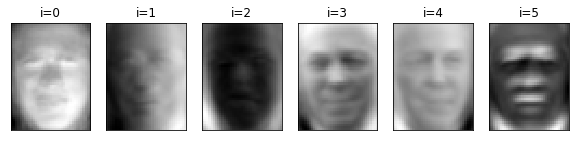

In [12]:
nplt = 6
plt.figure(figsize=(10, 20))
for i in range(nplt):
    plt.subplot(1,nplt,i+1)
    Vi = V[i,:]
    plt_face(V[i,:])
    plt.title('i={0:d}'.format(i))

## Face Classification using PCA Coefficients

We will use SVM to classify different faces based on PCA coefficients

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

First of all, we need to seperate X and y to X_train, X_test, y_train, y_test. Sklearn provides train_test_split() function to make it easily. Given the relatively small amount of data, we will enable the "stratify" option to make sure that the training set has the same proportion of different classes as the total dataset.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=43)

We will recompute the eigenfaces (principle components) using the training data only.

In [18]:
n_samples, _ = X_train.shape
Xtr_mean = np.mean(X_train,0)
Xtr = X_train - Xtr_mean[None,:]
Utr,Str,Vtr = np.linalg.svd(Xtr, full_matrices=False)

We will use the coefficients corresponding to 100 principle components for classification. In practice, this needs to be optimized.  We first get eigenfaces and eigen coefficients on training set.

In [19]:
npc = 100
eigenface = Vtr[:npc,:]
Xtr_pca = Xtr.dot(eigenface.T)

# Note we can also use
# Xtr_pca = Utr[:, :nsvd]*Str[None, :spc]

To use SVM, we should rescale the input features so that they all have unit variance.  Because the PCA coefficients have significantly different variances, this is particularly important. With SVD, the variance = eigenvalue = singular_value^2 / n_samples. So STD= singular_vale/sqrt(n_sample). Note that instead of scaling the PCA coefficients, one can also scale the principle components. So that using the scaled principle components, the coefficients will have unit variances.

In [20]:
Xtr_pca_s = Xtr_pca / Str[None,:npc] * np.sqrt(n_samples)

We will use GridSearchCV within the training data to find the optimal SVM setting from different combination of C and gamma 

In [22]:
param_grid = {'C': [0.1, 1, 1e1, 5e1, 1e2, 5e2],
              'gamma': [0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(Xtr_pca_s, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Cross validation accuracy with best estimator:")
print(clf.best_score_)

Best estimator found by grid search:
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Cross validation accuracy with best estimator:
0.843685300207


Now we evaluate the model accuracy on the test set. Note that we must do the same data processing for the test set to generate the scaled PCA coefficients.

In [23]:
Xts = X_test - Xtr_mean[None,:]
Xts_pca = Xts.dot(eigenface.T)
Xts_pca_s = Xts_pca / Str[None,:npc] * np.sqrt(n_samples)
y_hat = clf.predict(Xts_pca_s)
acc = np.mean(y_hat==y_test)
print("The model accuracy on the test set is %f" % acc)

The model accuracy on the test set is 0.844720


We can use following tools to print classification performance.

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_hat, target_names=target_names))
print("Confusion matrix on the test data")
print(confusion_matrix(y_test, y_hat, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.74      0.72        19
     Colin Powell       0.76      0.88      0.82        59
  Donald Rumsfeld       0.74      0.77      0.75        30
    George W Bush       0.95      0.88      0.91       133
Gerhard Schroeder       0.81      0.81      0.81        27
      Hugo Chavez       0.93      0.78      0.85        18
       Tony Blair       0.79      0.83      0.81        36

      avg / total       0.85      0.84      0.85       322

Confusion matrix on the test data
[[ 14   3   2   0   0   0   0]
 [  1  52   1   3   1   0   1]
 [  3   1  23   2   1   0   0]
 [  1   6   4 117   2   1   2]
 [  0   0   0   1  22   0   4]
 [  0   3   0   0   0  14   1]
 [  1   3   1   0   1   0  30]]


We can plot some correct classified images and misclassifed images in test set

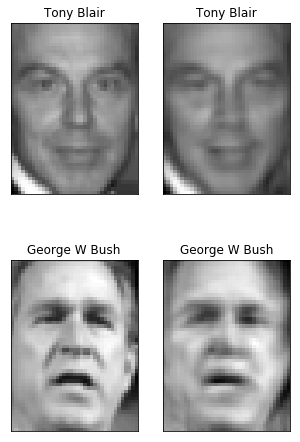

In [25]:
correct_index = np.where(y_hat==y_test)[0][:2]
correct_origin = X_test[correct_index, :]
correct_pca = Xts_pca[correct_index, :].dot(eigenface) +  Xtr_mean[None,:]
plt.figure(figsize=(5, 8))
for i in range(2):
    plt.subplot(2,2,2*i+1)
    plt_face(correct_origin[i,:])
    plt.title(target_names[y_test[correct_index[i]]])
    
    plt.subplot(2,2,2*i+2)
    plt_face(correct_pca[i,:])
    plt.title(target_names[y_hat[correct_index[i]]])
plt.show()

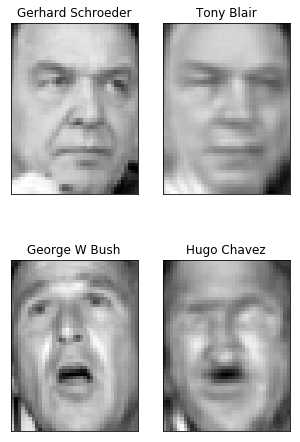

In [26]:
wrong_index = np.where(y_hat!=y_test)[0][:2]
wrong_origin = X_test[wrong_index, :]
wrong_pca = Xts_pca[wrong_index, :].dot(eigenface) +  Xtr_mean[None,:]
plt.figure(figsize=(5, 8))
for i in range(2):
    plt.subplot(2,2,2*i+1)
    plt_face(wrong_origin[i,:])
    plt.title(target_names[y_test[wrong_index[i]]])
    
    plt.subplot(2,2,2*i+2)
    plt_face(wrong_pca[i,:])
    plt.title(target_names[y_hat[wrong_index[i]]])
plt.show()

We see that the failure cases may be caused by the pose difference of the test data from the majority of the training data.